In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import regex as re

#### BatteryManager Processer script

In [2]:
HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def reset_timestamp(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = reset_timestamp(df)
    df = calculate_power(df)
    df.to_csv(f'.\\{data_path.strip(".log")}.csv', index=False)
    return df

def process_BM():
    df_aggregated = pd.DataFrame(columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if name == 'battery_manager.log':
                # print(os.path.join(root, name))
                energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                device = root.split('\\')[1]
                app = root.split('\\')[2].strip('-W')
                app_details = root.split('\\')[3]
                is_record = 'record' in root.split('\\')[4]
                is_wireless = '-W' in root.split('\\')[2]
                repetition = root.split('\\')[4].strip('record') if 'record' in root.split('\\')[4] else root.split('\\')[4].strip('replay')
                df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])
    return df_aggregated

In [3]:
bm = process_BM().reset_index(drop=True)

# normalized energy consumption for better comparison
bm['Energy per Second (J/s)'] = bm['energy(J)'] / bm['length(s)']
bm.to_csv('overall_energy.csv', index=False)

C:\Users\radua\AppData\Local\Temp\ipykernel_18084\3317343466.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


# Plots

In [4]:
# set all the figure fonts to Arial
plt.rcParams['font.family'] = 'Arial'

### Totals per device

<Axes: xlabel='device', ylabel='Energy per Second (J/s)'>

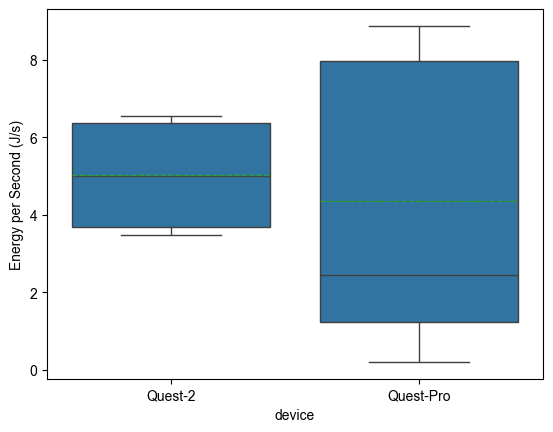

In [5]:
sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanline=True)

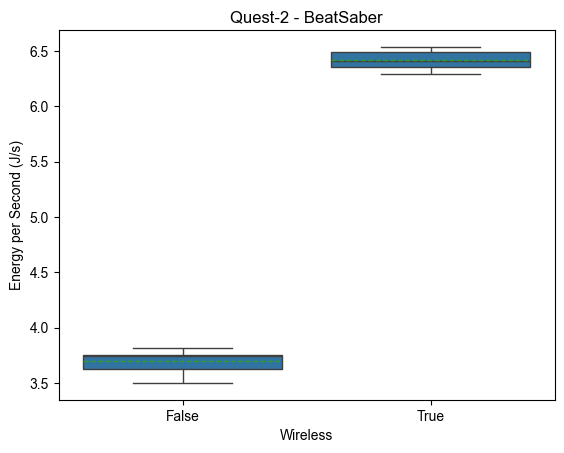

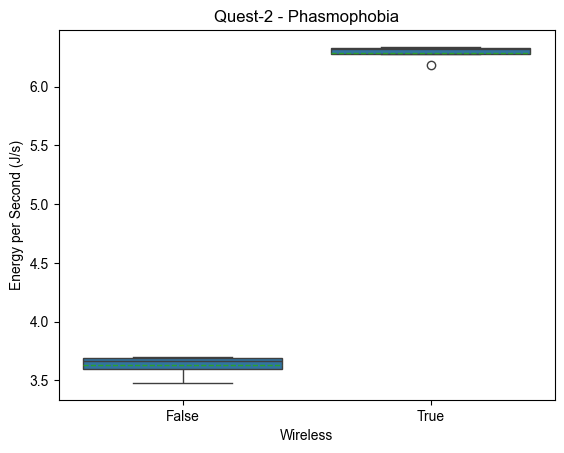

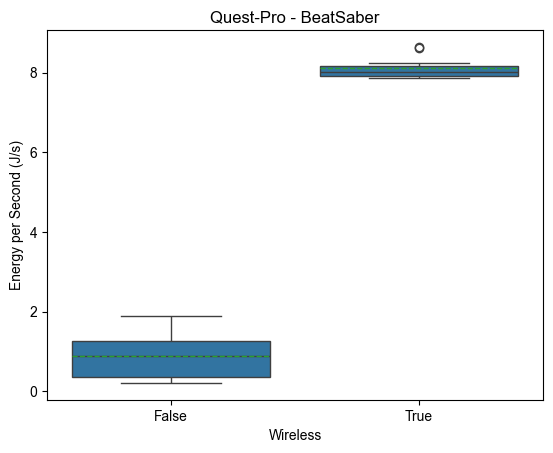

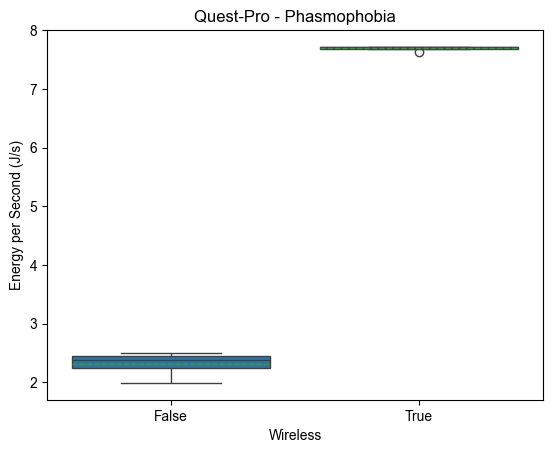

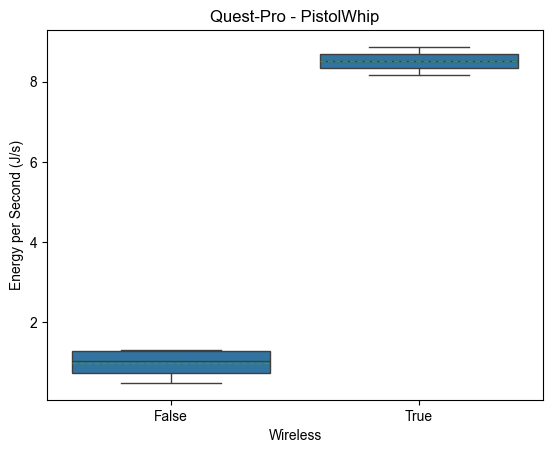

In [6]:
for device in bm['device'].unique():
    tmp = bm[bm['device'] == device]

    for app in tmp['app'].unique():
        tmp2 = tmp[tmp['app'] == app]
        fig, ax = plt.subplots()
        sns.boxplot(data=tmp2, x='is_wireless', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax)
        ax.set_title(device + ' - ' + app)
        ax.set_xlabel('Wireless')
        plt.show()

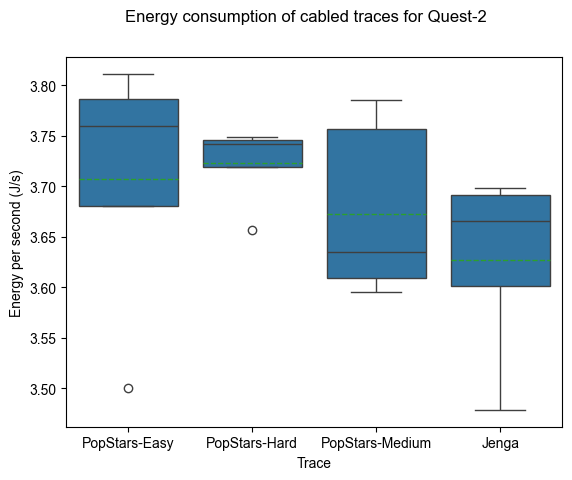

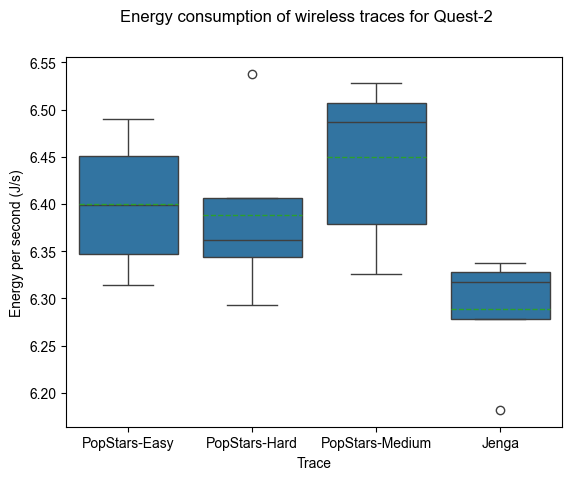

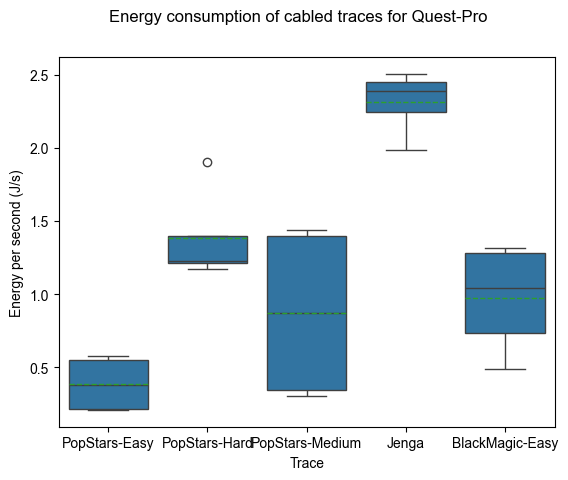

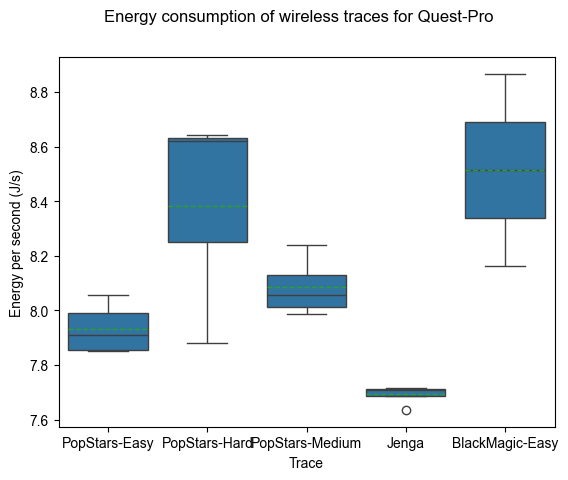

In [7]:
for device in bm['device'].unique():
    tmp = bm[bm['device'] == device]

    for wireless in tmp['is_wireless'].unique():
        tmp2 = tmp[tmp['is_wireless'] == wireless]
        axes = sns.boxplot(data=tmp2, x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=plt.gca())
        fig = axes.get_figure()
        if wireless:
            fig.suptitle("Energy consumption of wireless traces for " + device)
        else:
            fig.suptitle("Energy consumption of cabled traces for " + device)
        # set x-axis label
        axes.set_xlabel("Trace")
        # set y-axis label
        axes.set_ylabel("Energy per second (J/s)")

        plt.show()